In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data.csv")

In [3]:
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [4]:
df.tail()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
190,phon_R01_S50_2,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,...,0.07008,0.02764,19.517,0,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,phon_R01_S50_3,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,...,0.04812,0.01810,19.147,0,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,phon_R01_S50_4,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,...,0.03804,0.10715,17.883,0,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,phon_R01_S50_5,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,...,0.03794,0.07223,19.020,0,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306
194,phon_R01_S50_6,214.289,260.277,77.973,0.00567,0.00003,0.00295,0.00317,0.00885,0.01884,...,0.03078,0.04398,21.209,0,0.462803,0.664357,-5.724056,0.190667,2.555477,0.148569


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [6]:
df.rename(columns = {"status":"target"},inplace=True)

In [7]:
df = df.drop(columns="name",axis=1)

In [8]:
df.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,target,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


<AxesSubplot:>

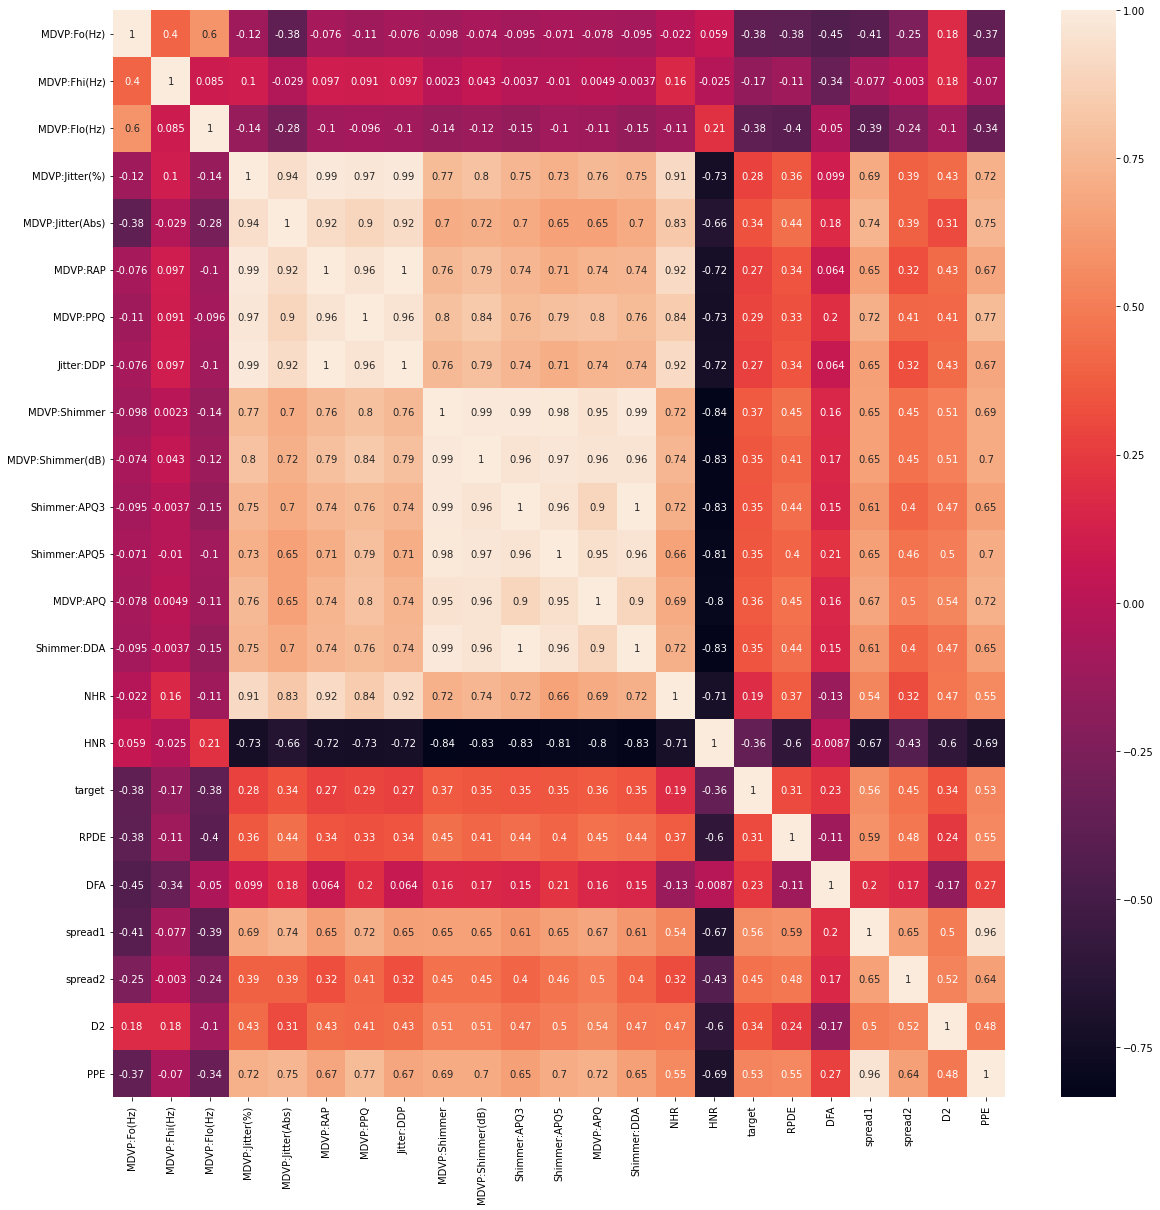

In [9]:
import seaborn as sns 

plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=True,fmt=".2g")

# FEATURE SELECTION METHOD = CORRELATION MATRIX

In [10]:
corr_matrix = df.corr()
corr_row = corr_matrix.loc["target"]
corr_row = [round(element, 2) for element in corr_row]
unique_corr_row = list(set(corr_row))

# Update the original DataFrame to contain only the columns corresponding to the values in unique_corr_row
df = df[[corr_matrix.columns[corr_row.index(element)] for element in unique_corr_row]]
print(df.shape)

(195, 17)


In [11]:
df.groupby("target").mean()

,MDVP:Fo(Hz),MDVP:Jitter(%),MDVP:Fhi(Hz),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,MDVP:Shimmer,MDVP:Shimmer(dB),MDVP:APQ,NHR,DFA,spread1,PPE,spread2,HNR,RPDE
target,,,,,,,,,,,,,,,,
0,181.937771,0.003866,223.636750,0.000023,0.001925,0.002056,0.017615,0.162958,0.013305,0.011483,0.695716,-6.759264,0.123017,0.160292,24.678750,0.442552
1,145.180762,0.006989,188.441463,0.000051,0.003757,0.003900,0.033658,0.321204,0.027600,0.029211,0.725408,-5.333420,0.233828,0.248133,20.974048,0.516816


<AxesSubplot:xlabel='target', ylabel='count'>

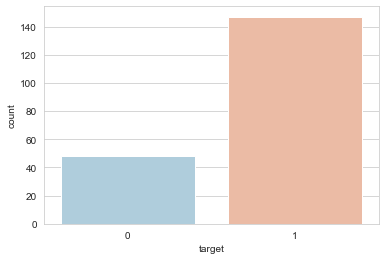

In [12]:
df["target"].value_counts()

sns.set_style("whitegrid")
sns.countplot(x="target",data=df, palette="RdBu_r")

In [13]:
X = df.drop(columns="target",axis=1)
Y = df["target"]

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standardized_X = scaler.fit_transform(X)
X = standardized_X
Y = df["target"]

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.20,stratify=Y,random_state=42)
print(X.shape, X_train.shape, X_test.shape)

(195, 16) (156, 16) (39, 16)


In [16]:
from sklearn import svm

svm_classifier = svm.SVC(kernel="linear")
svm_classifier.fit(X_train,Y_train)

SVC(kernel='linear')

In [17]:
from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression()
lr_classifier.fit(X_train,Y_train)

LogisticRegression()

In [18]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train,Y_train)

DecisionTreeClassifier()

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train,Y_train)

RandomForestClassifier()

In [20]:
from sklearn.metrics import accuracy_score

#SVM
X_train_prediction_SVM = svm_classifier.predict(X_train)
train_acc_SVM = accuracy_score(X_train_prediction_SVM,Y_train)

X_test_prediction_SVM = svm_classifier.predict(X_test)
test_acc_SVM = accuracy_score(X_test_prediction_SVM,Y_test)

#Logistic Regression
X_train_prediction_lr = lr_classifier.predict(X_train)
train_acc_lr = accuracy_score(X_train_prediction_lr,Y_train)

X_test_prediction_lr = lr_classifier.predict(X_test)
test_acc_lr = accuracy_score(X_test_prediction_lr,Y_test)

#Decision Tree
X_train_prediction_dt = dt_classifier.predict(X_train)
train_acc_dt = accuracy_score(X_train_prediction_dt,Y_train)

X_test_prediction_dt = dt_classifier.predict(X_test)
test_acc_dt = accuracy_score(X_test_prediction_dt,Y_test)

#Random Forest
X_train_prediction_rf = rf_classifier.predict(X_train)
train_acc_rf = accuracy_score(X_train_prediction_rf,Y_train)

X_test_prediction_rf = rf_classifier.predict(X_test)
test_acc_rf = accuracy_score(X_test_prediction_rf,Y_test)

print("Training Accuracy:-\n1. SVM\t\t\t",train_acc_SVM,"\n2. Logistic Regression\t",train_acc_lr,"\n3. Decision Tree\t",train_acc_dt,"\n4. Random Forest\t",train_acc_rf)
print("\n\nTest Accuracy:-\n1. SVM\t\t\t",test_acc_SVM,"\n2. Logistic Regression\t",test_acc_lr,"\n3. Decision Tree\t",test_acc_dt,"\n4. Random Forest\t",test_acc_rf)

Training Accuracy:-
1. SVM			 0.8974358974358975 
2. Logistic Regression	 0.8653846153846154 
3. Decision Tree	 1.0 
4. Random Forest	 1.0


Test Accuracy:-
1. SVM			 0.9230769230769231 
2. Logistic Regression	 0.8974358974358975 
3. Decision Tree	 0.7948717948717948 
4. Random Forest	 0.8974358974358975


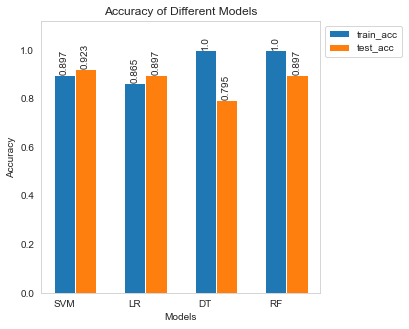

In [21]:
algo_names = ["SVM","LR","DT","RF"]
train_acc = [round(train_acc_SVM,3),round(train_acc_lr,3),round(train_acc_dt,3),round(train_acc_rf,3)]
test_acc =[round(test_acc_SVM,3),round(test_acc_lr,3),round(test_acc_dt,3),round(test_acc_rf,3)]
X_axis = np.arange(len(algo_names))

plt.figure(figsize=(5,5))
bar_width = 0.3
plt.bar(algo_names, train_acc, width=bar_width, align='center', label='train_acc')
plt.bar([i + bar_width for i in range(len(algo_names))], test_acc, width=bar_width, align='center', label='test_acc')

for i, model in enumerate(algo_names):
    plt.text(i, train_acc[i], str(train_acc[i]), ha='center', va='bottom', rotation=90)
    plt.text(i + bar_width, test_acc[i], str(test_acc[i]), ha='center', va='bottom', rotation=90)

plt.xticks(X_axis, algo_names)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy of Different Models")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.ylim(top=max(max(train_acc), max(test_acc)) + 0.12)
plt.grid(visible=False)
plt.show()

In [22]:
import pickle

filename = "parkinsons.sav"
pickle.dump(svm_classifier,open(filename,"wb"))

In [23]:
loaded_model = pickle.load(open("parkinsons.sav","rb"))